In [2]:
import numpy as np
import pandas as pd
from plotnine import *
from mizani.formatters import percent_format
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import minimize
import statsmodels.api as sm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data Preparation and Prices Plot

         Date Ticker        Open        High         Low       Close  \
0  2020-01-03    JPM  137.500000  139.229996  137.080002  138.339996   
1  2020-01-03     KO   54.320000   54.990002   54.090000   54.689999   
2  2020-01-03    LMT  404.019989  417.170013  403.000000  413.739990   
3  2020-01-03     MS   51.220001   51.450001   50.830002   51.200001   
4  2020-01-03   MSCI  262.200012  263.579987  259.269989  260.750000   

     Adjusted   Returns    Volume  
0  119.874146 -0.013197  10386800  
1   46.494701 -0.005455  11354500  
2  359.312286  0.035982   2990100  
3   43.273083 -0.016141   6706000  
4  248.019440 -0.019921    459700  


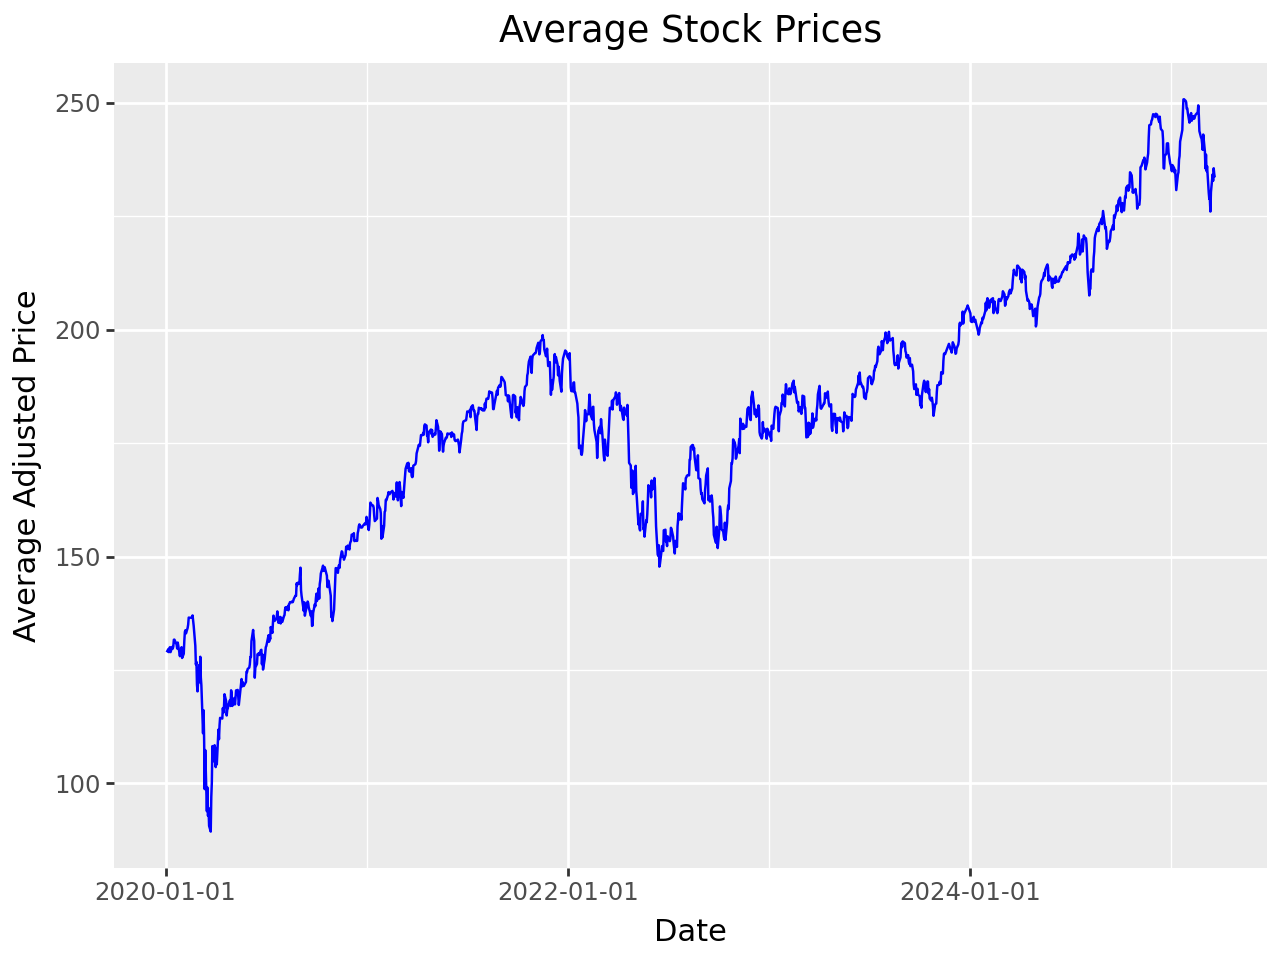

In [3]:
def current_date():
    today = datetime.today().date()
    return today


def price_plot(prices):
    plot_title = "Average Stock Prices"

    prices["Date"] = pd.to_datetime(prices["Date"])

    avg_prices = prices.groupby("Date", as_index=False)["Adjusted"].mean()

    plot = (
        ggplot(avg_prices, aes(x="Date", y="Adjusted", group=1)) +  # <-- добавляем group=1
        geom_line(color="blue") +
        labs(title=plot_title, x="Date", y="Average Adjusted Price")
    )

    display(plot)


weights_df  = pd.read_csv('data/Portfolio.csv')
tickers = weights_df ['Ticker'].tolist()
prices = pd.read_csv('data/Portfolio_prices.csv')

print(prices.head())
price_plot(prices)

## Returns and Portfolio Metrics

Portfolio mean return: 0.07836273307645604
Portfolio standard deviation (volatility): 1.3711283699952566
Sharpe ratio: 0.042565476984957974
Sortino ratio: 3.020433696735681
Returns statistics

         count   mean    std    min    25%    50%    75%    max
Ticker                                                         
AAPL    1311.0  0.001  0.020 -0.129 -0.008  0.001  0.012  0.120
ADAP    1311.0  0.001  0.084 -0.376 -0.030 -0.005  0.025  2.000
AGCO    1311.0  0.001  0.025 -0.188 -0.013  0.001  0.014  0.200
BA      1311.0  0.000  0.032 -0.238 -0.015 -0.000  0.014  0.243
BG      1311.0  0.001  0.021 -0.143 -0.009  0.001  0.012  0.145
CALM    1311.0  0.001  0.021 -0.145 -0.009  0.001  0.011  0.151
CAT     1311.0  0.001  0.020 -0.143 -0.010  0.001  0.012  0.103
CSCO    1311.0  0.000  0.017 -0.137 -0.007  0.000  0.008  0.134
CVX     1311.0  0.001  0.022 -0.221 -0.009  0.001  0.010  0.227
DDOG    1311.0  0.001  0.037 -0.179 -0.017  0.002  0.019  0.285
DE      1311.0  0.001  0.021 -0.141 -0.

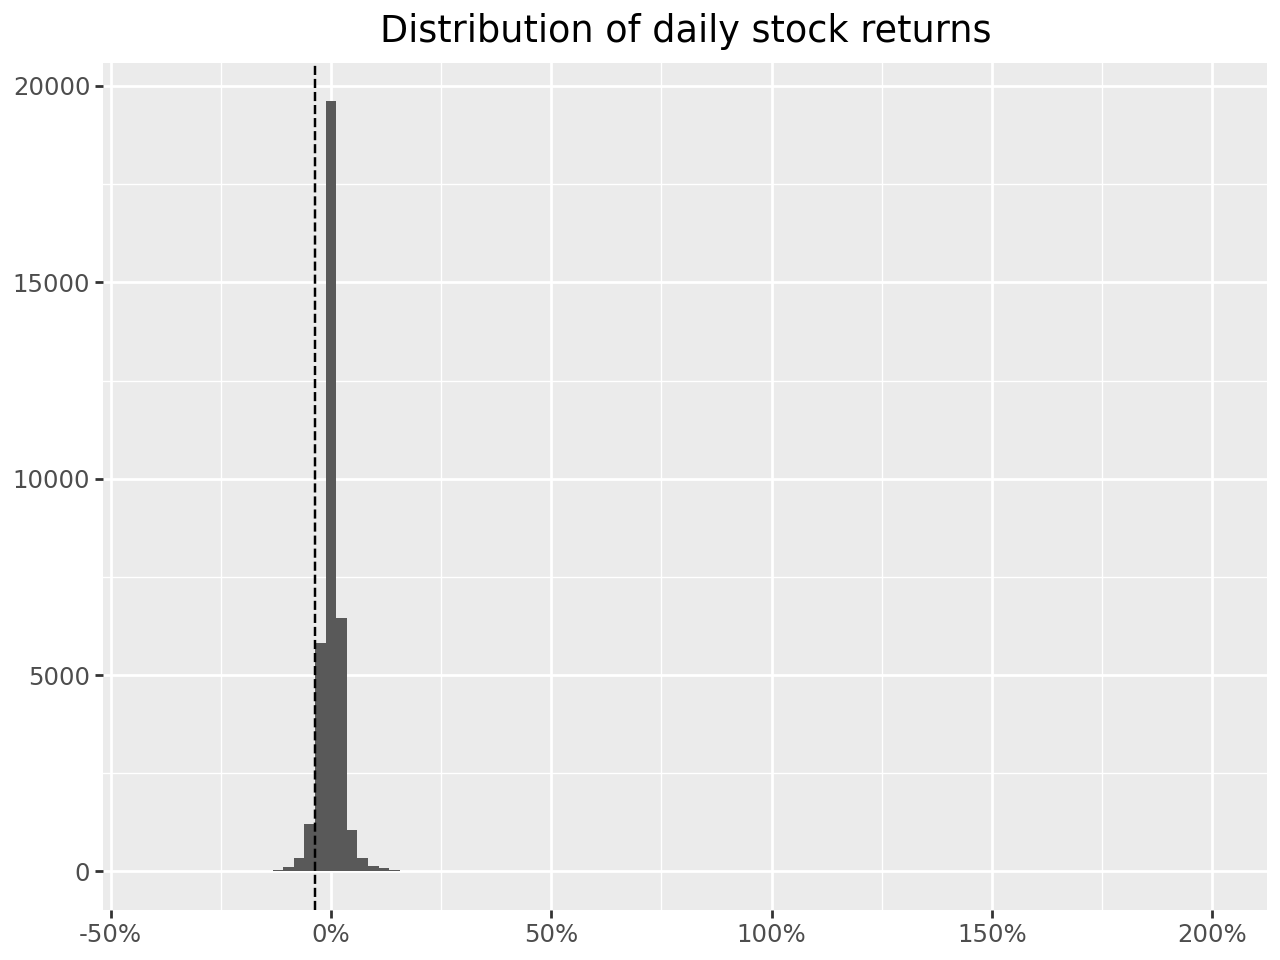

In [4]:
def multiple_returns_statistics(returns, decimal=3):
    print("Returns statistics\n")
    print(returns.groupby("Ticker")["Returns"].describe().round(decimal))

def returns_plot(returns):
    plot_title = "Distribution of daily stock returns"
    quantile_05 = returns["Returns"].quantile(0.05)

    returns_figure = (ggplot(returns, aes(x="Returns")) 
                      + geom_histogram(bins=100) 
                      + geom_vline(aes(xintercept=quantile_05), linetype="dashed")
                      + labs(x="", y="", title=plot_title)
                      + scale_x_continuous(labels=percent_format()))

    display(returns_figure)

# Ensure correct data types
prices['Date'] = pd.to_datetime(prices['Date'])

# Merge prices with weights_df on 'Ticker'
merged_df = pd.merge(prices, weights_df[['Ticker', 'Weight']], on='Ticker', how='inner')

# Sort merged dataframe
merged_df = merged_df.sort_values(by=['Date', 'Ticker'])

# Pivot table for returns
pivoted_returns = merged_df.pivot_table(index='Date', columns='Ticker', values='Returns')

# Calculate mean returns for each ticker
mean_returns = pivoted_returns.mean()

# Portfolio mean return
portfolio_return = np.dot(mean_returns, weights_df.set_index('Ticker')['Weight'])
print(f"Portfolio mean return: {portfolio_return}")

# Covariance matrix of returns
cov_matrix = pivoted_returns.cov()

# Portfolio standard deviation (volatility)
portfolio_volatility = np.sqrt(np.dot(weights_df.set_index('Ticker')['Weight'].T, 
                                      np.dot(cov_matrix, weights_df.set_index('Ticker')['Weight'])))
print(f"Portfolio standard deviation (volatility): {portfolio_volatility}")

# Sharpe ratio calculation
risk_free_rate = 0.02  # example risk-free rate, modify as needed
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
print(f"Sharpe ratio: {sharpe_ratio}")

# Sortino ratio calculation (considering negative returns only)
negative_returns = merged_df[merged_df['Returns'] < 0]['Returns']
downside_std_dev = negative_returns.std()
sortino_ratio = (portfolio_return - risk_free_rate) / downside_std_dev
print(f"Sortino ratio: {sortino_ratio}")

# Print summary statistics and plot returns
multiple_returns_statistics(merged_df)
returns_plot(merged_df)


## Trading volume

C:\Users\nikit\PycharmProjects\COVID19_Project\.venv\Personal_portfolio_analysis\Lib\site-packages\mizani\breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


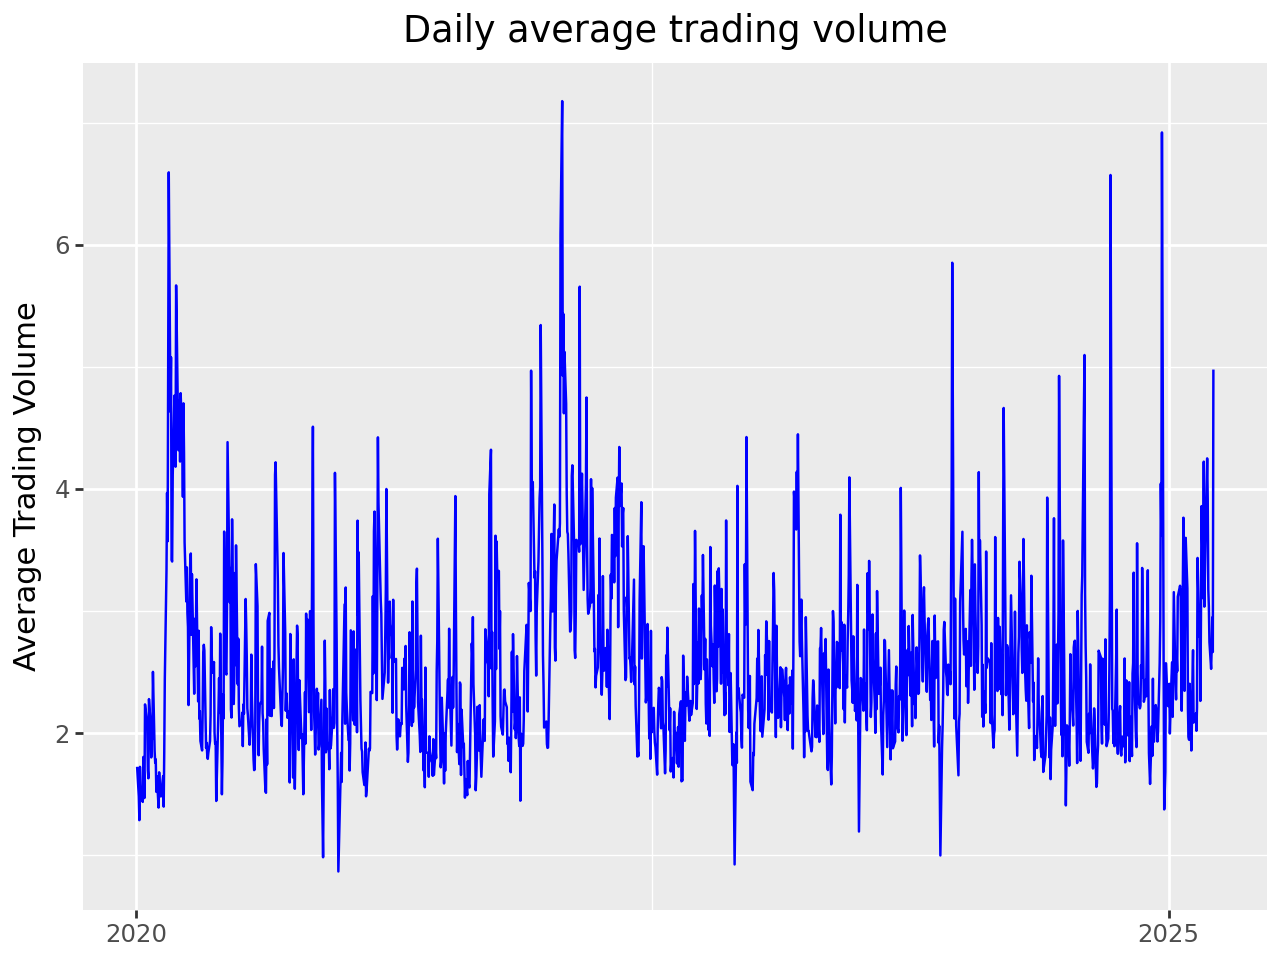

C:\Users\nikit\PycharmProjects\COVID19_Project\.venv\Personal_portfolio_analysis\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


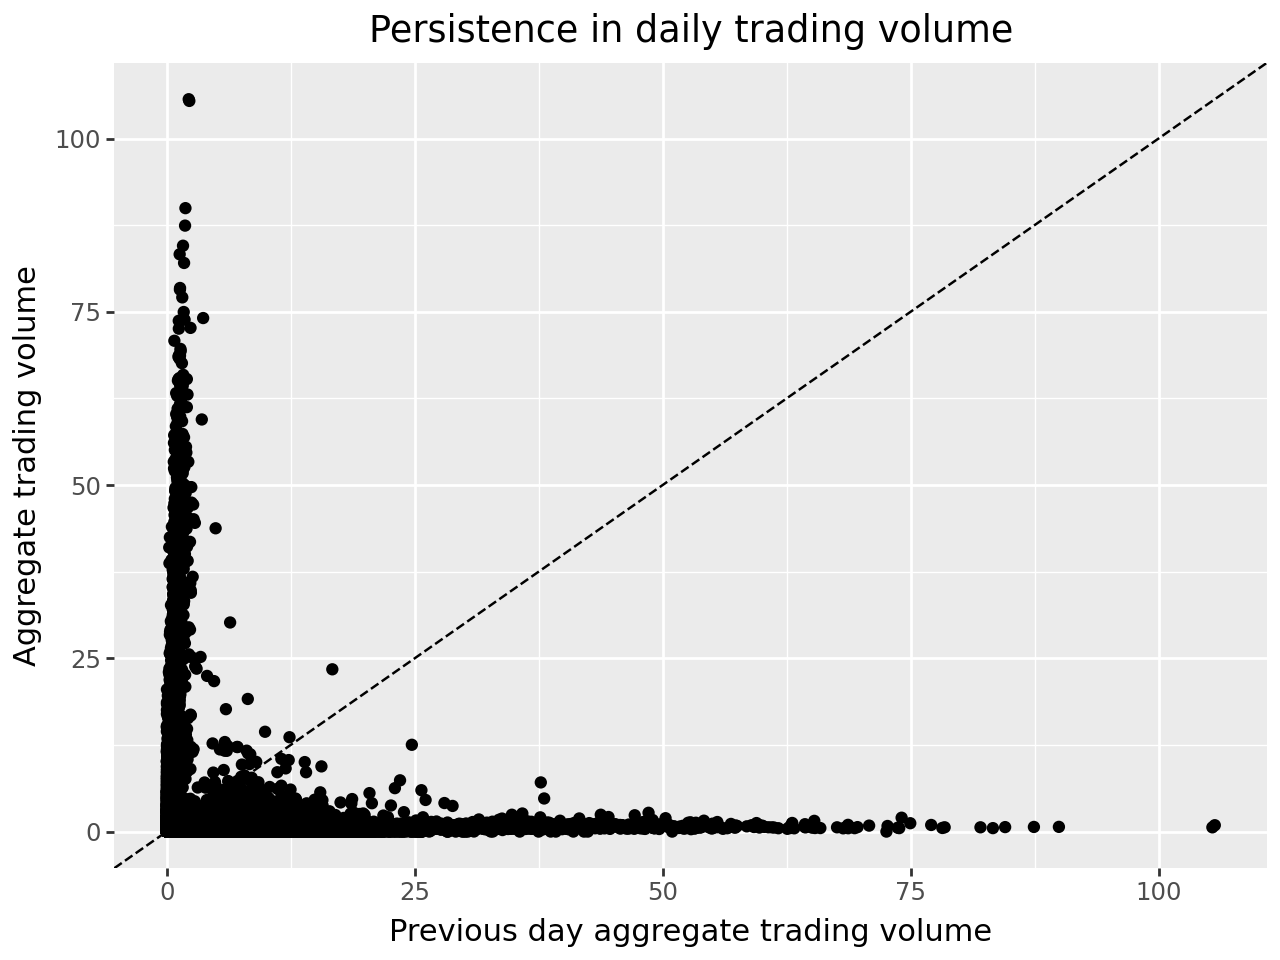

In [5]:
def calculate_trading_volume(prices):
    prices["Date"] = pd.to_datetime(prices["Date"])

    trading_volume = (
        prices
        .assign(Trading_volume=lambda x: (x["Volume"] * x["Adjusted"]) / 1e9)
        .groupby(["Date", "Ticker"], as_index=False)
        .agg({"Trading_volume": "sum"})
        .assign(Trading_volume_lag=lambda x: x["Trading_volume"].shift(periods=1))
    )
    return trading_volume

def trading_volume_plot(trading_volume, persistence=False, multi=False):
    if trading_volume.empty:
        print("⚠️ Warning: Empty trading volume DataFrame")
        return
    
    trading_volume["Date"] = pd.to_datetime(trading_volume["Date"])

    avg_trading_volume = trading_volume.groupby("Date", as_index=False)["Trading_volume"].mean()

    if persistence:
        plot_title = "Persistence in daily trading volume"
        trading_volume_figure = (
            ggplot(trading_volume, aes(x="Trading_volume_lag", y="Trading_volume")) +
            geom_point() +
            geom_abline(intercept=0, slope=1, linetype="dashed") +
            labs(x="Previous day aggregate trading volume", y="Aggregate trading volume", title=plot_title)
        )
    else:
        plot_title = "Daily average trading volume"
        trading_volume_figure = (
            ggplot(avg_trading_volume, aes(x="Date", y="Trading_volume")) +
            geom_line(color="blue") +  
            labs(x="", y="Average Trading Volume", title=plot_title) +
            scale_x_date(date_breaks="5 years", date_labels="%Y")
        )

    display(trading_volume_figure)


trading_volume = calculate_trading_volume(prices)
trading_volume_plot(trading_volume)
trading_volume_plot(trading_volume, persistence=True)

## VaR & CVaR

VaR (Historical Method) at 95.0% confidence level: -0.0360


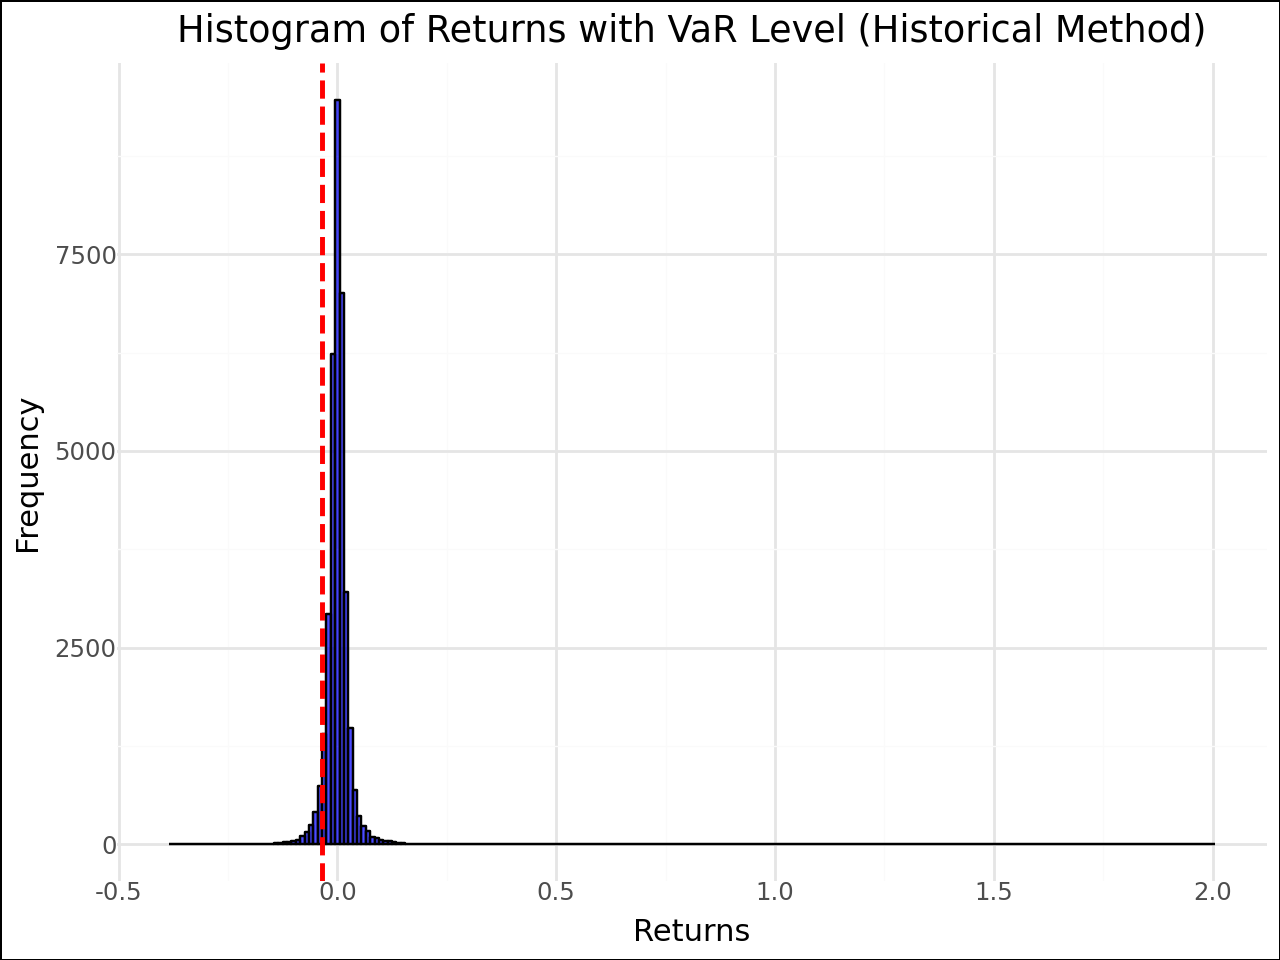

VaR (Parametric Method) at 95.0% confidence level: -0.0464


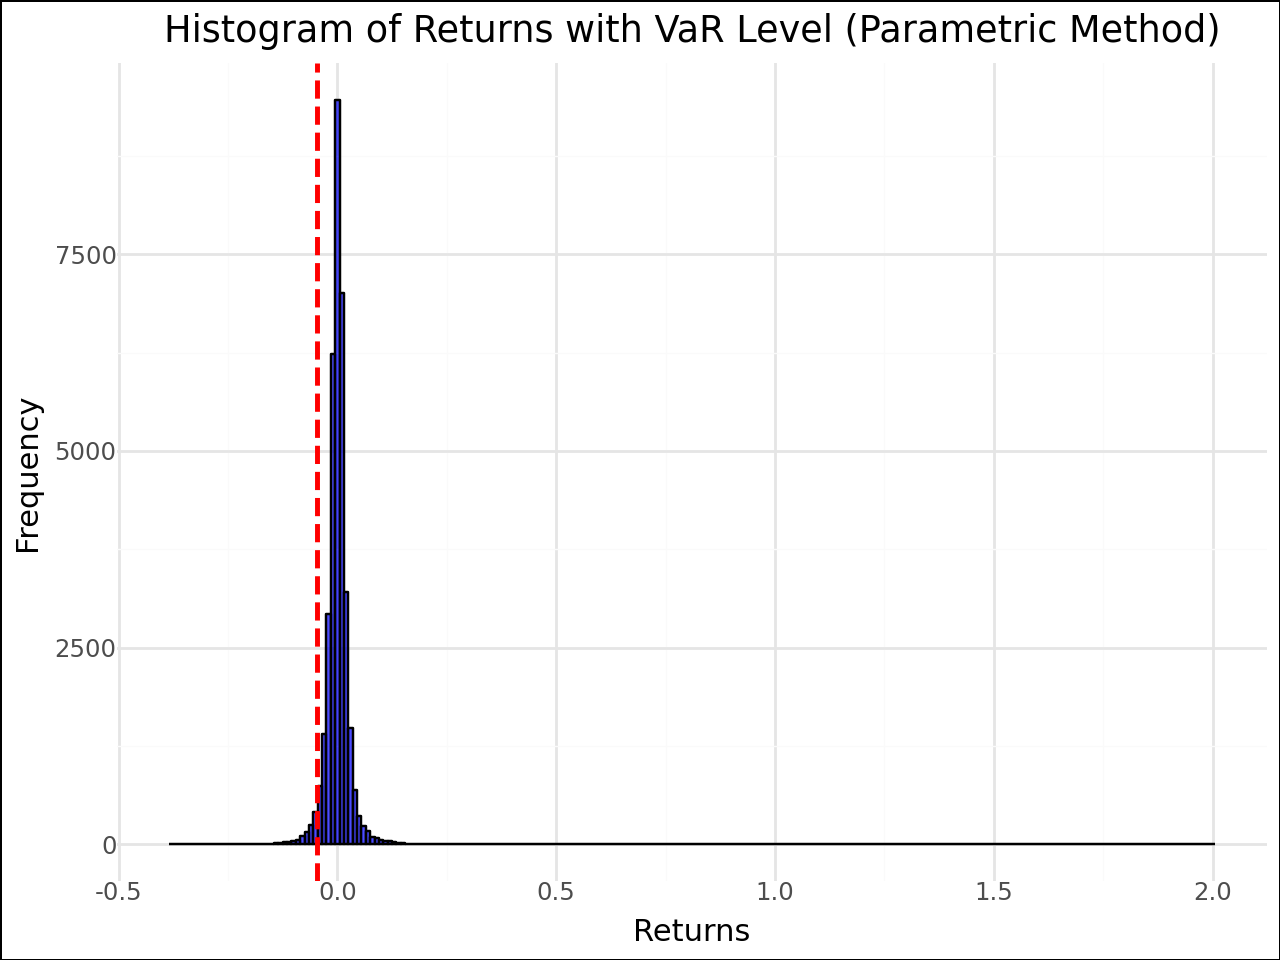

VaR (Historical Method) at 95.0% confidence level: -0.0360
CVaR (Historical Method) at 95.0% confidence level: -0.0593


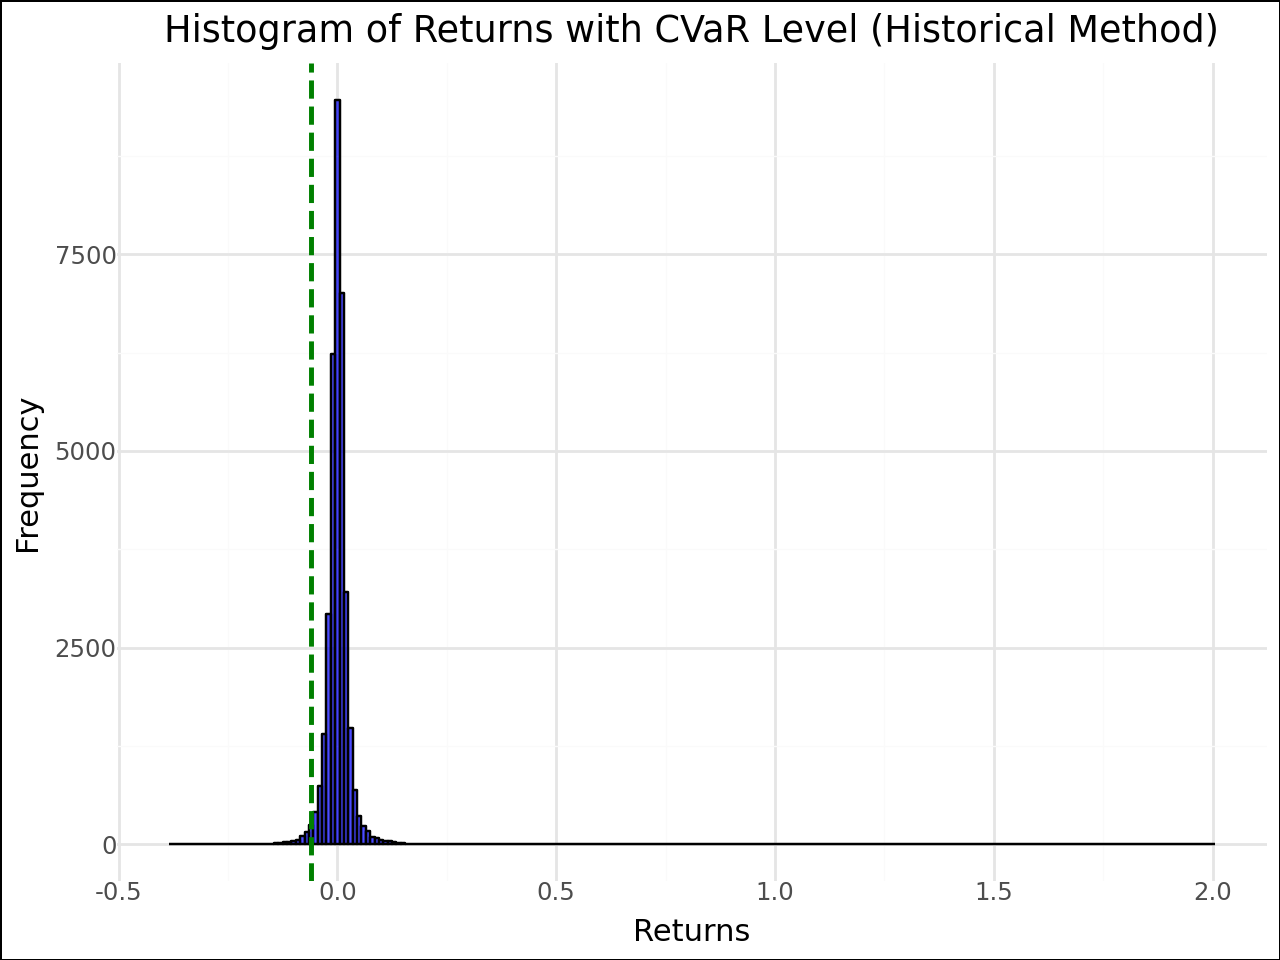

VaR (Parametric Method) at 95.0% confidence level: -0.0464
CVaR (Parametric Method) at 95.0% confidence level: -0.0583


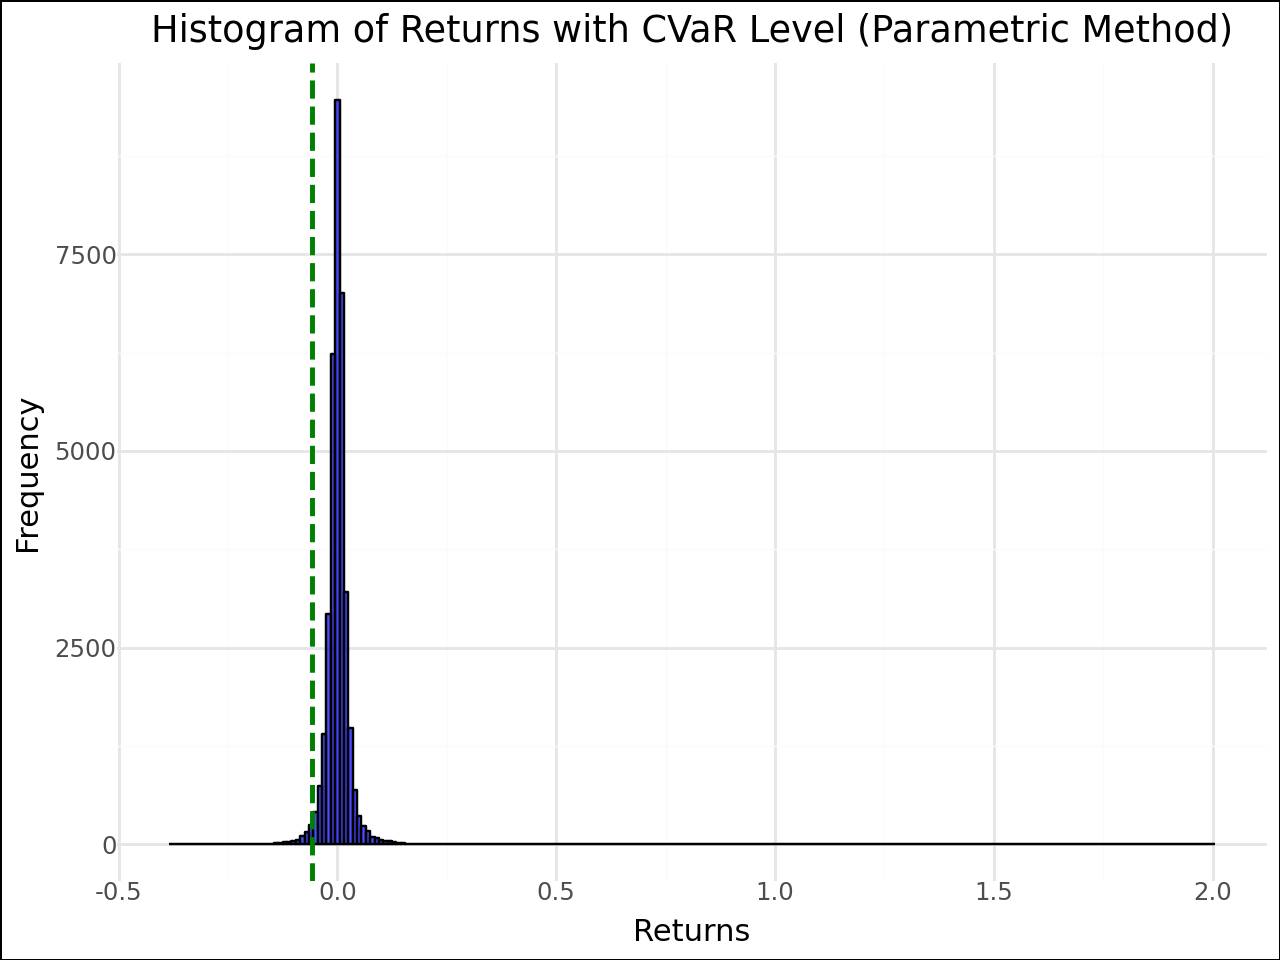

In [6]:
def var(data, method="hist", confidence_level=0.95):
    if method == "hist":
        var_hist = data["Returns"].quantile(1 - confidence_level)
        print(f"VaR (Historical Method) at {confidence_level * 100}% confidence level: {var_hist:.4f}")
        return var_hist
    elif method == "parametric":
        mean_return = data["Returns"].mean()
        std_dev = data["Returns"].std()
        z_score = norm.ppf(1 - confidence_level)  # Z-score for given confidence level

        var_parametric = mean_return + z_score * std_dev  # Parametric VaR formula
        print(f"VaR (Parametric Method) at {confidence_level * 100}% confidence level: {var_parametric:.4f}")
        return var_parametric
    else:
        raise ValueError("Method must be 'hist' or 'parametric'.")


def cvar(data, method="hist", confidence_level=0.95):
    """Calculate Conditional Value at Risk (CVaR)"""
    var_value = var(data, method, confidence_level)

    if method == "hist":
        cvar_hist = data[data["Returns"] <= var_value]["Returns"].mean()
        print(f"CVaR (Historical Method) at {confidence_level * 100}% confidence level: {cvar_hist:.4f}")
        return cvar_hist

    elif method == "parametric":
        mean_return = data["Returns"].mean()
        std_dev = data["Returns"].std()
        z_score = norm.ppf(1 - confidence_level)

        cvar_parametric = mean_return - (std_dev * norm.pdf(z_score) / (1 - confidence_level))
        print(f"CVaR (Parametric Method) at {confidence_level * 100}% confidence level: {cvar_parametric:.4f}")
        return cvar_parametric

    else:
        raise ValueError("Method must be 'hist' or 'parametric'.")


def var_plot(data, method="hist", confidence_level=0.95):
    var_data = var(data, method=method, confidence_level=confidence_level)
    if method == "hist":
        plot_title = "Histogram of Returns with VaR Level (Historical Method)"
    elif method == "parametric":
        plot_title = "Histogram of Returns with VaR Level (Parametric Method)"
    plot = (
            ggplot(data, aes(x="Returns")) +
            geom_histogram(binwidth=0.01, fill="blue", alpha=0.7, color="black") +
            geom_vline(xintercept=var_data, color="red", linetype="dashed", size=1) +
            labs(
                title=plot_title,
                x="Returns",
                y="Frequency"
            ) +
            theme_minimal() +
            theme(
                panel_background=element_rect(fill="white"),
                plot_background=element_rect(fill="white")
            )
    )
    display(plot)


def cvar_plot(data, method="hist", confidence_level=0.95, multi=False):
    cvar_data = cvar(data, method=method, confidence_level=confidence_level)
    if method == "hist":
        plot_title = "Histogram of Returns with CVaR Level (Historical Method)"
    elif method == "parametric":
        plot_title = "Histogram of Returns with CVaR Level (Parametric Method)"
    plot = (
            ggplot(data, aes(x="Returns")) +
            geom_histogram(binwidth=0.01, fill="blue", alpha=0.7, color="black") +
            geom_vline(xintercept=cvar_data, color="green", linetype="dashed", size=1) +
            labs(
                title=plot_title,
                x="Returns",
                y="Frequency"
            ) +
            theme_minimal() +
            theme(
                panel_background=element_rect(fill="white"),
                plot_background=element_rect(fill="white")
            )
    )
    display(plot)


var_plot(prices)
var_plot(prices, method = "parametric")
cvar_plot(prices)
cvar_plot(prices, method = "parametric")

## Beta

In [8]:
market_returns = pd.read_csv('data/NASDAQ.csv')
market_returns = market_returns.rename(columns={'Returns': 'Market_Returns'})


asset_returns_df = prices
asset_returns_df = asset_returns_df.rename(columns={'Returns': 'Asset_Returns'}) 

market_returns['Date'] = pd.to_datetime(market_returns['Date'])
asset_returns_df['Date'] = pd.to_datetime(asset_returns_df['Date'])

def calculate_beta(asset_returns, market_returns):
    data = pd.merge(asset_returns, market_returns, on='Date')
    
    X = sm.add_constant(data['Market_Returns'])  
    y = data['Asset_Returns']
    
    model = sm.OLS(y, X).fit()
    
    beta = model.params[1]  
    return beta

betas = {}

for ticker in tickers:
    asset_returns = asset_returns_df[asset_returns_df['Ticker'] == ticker][['Date', 'Asset_Returns']]
    
    beta = calculate_beta(asset_returns, market_returns)
    betas[ticker] = beta  

for ticker, beta in betas.items():
    print(f"Beta for {ticker}: {beta}")

Beta for AAPL: 1.0217982331295012
Beta for ADAP: 1.1515073307839752
Beta for AGCO: 0.7143628731530716
Beta for BA: 1.020649176810295
Beta for BG: 0.47759920263076283
Beta for CALM: 0.22496492446866087
Beta for CAT: 0.6294116938160206
Beta for CSCO: 0.6673375897099043
Beta for CVX: 0.5817919908167464
Beta for DDOG: 1.3429739771852112
Beta for DE: 0.6216927206802754
Beta for GRWG: 1.5876437308422593
Beta for HUM: 0.49646868640066155
Beta for IBKR: 0.7319268541026758
Beta for IEX: 0.5938465995785714
Beta for JPM: 0.6915954394811424
Beta for KO: 0.35719174269213255
Beta for LMT: 0.30655472258569766
Beta for MS: 0.8882638639601005
Beta for MSCI: 0.9795187729209107
Beta for MSFT: 1.032699552382486
Beta for NFLX: 1.0363899967978778
Beta for OSK: 0.7392373625544428
Beta for PFE: 0.32382376569253524
Beta for PG: 0.334691169100992
Beta for SPY: 0.7751334563293079
Beta for TMUS: 0.5405648635650732


C:\Users\nikit\AppData\Local\Temp\ipykernel_9052\1596505501.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\nikit\AppData\Local\Temp\ipykernel_9052\1596505501.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\nikit\AppData\Local\Temp\ipykernel_9052\1596505501.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\nikit\AppData\Local\Temp\ipykernel_9052\1596505501.py:19: FutureWarning: Series.__getitem__ tr

## Portfolio Optimization 

In [7]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))


def portfolio_mean_return(weights, mean_returns):
    return np.dot(weights, mean_returns)


def optimize_portfolio(mean_returns, cov_matrix, target_return, tickers):
    def objective(weights):
        return portfolio_variance(weights, cov_matrix)
    
    constraints = (
        {'type': 'eq', 'fun': lambda weights: portfolio_mean_return(weights, mean_returns) - target_return},
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    )
    
    bounds = [(0, 1) for _ in range(len(mean_returns))]
    
    initial_guess = [1.0 / len(mean_returns) for _ in range(len(mean_returns))]
    
    result = minimize(objective, initial_guess, constraints=constraints, bounds=bounds)
    
    optimal_weights = result.x
    return dict(zip(tickers, optimal_weights))


target_return = 0.0005  

optimal_weights = optimize_portfolio(mean_returns, cov_matrix, target_return, tickers)
print(f"Optimal portfolio weights for target return {target_return}: {optimal_weights}")


Optimal portfolio weights for target return 0.0005: {'AAPL': 0.02141680406435839, 'ADAP': 0.0055783259255762635, 'AGCO': 0.04291391405623665, 'BA': 0.06858238893783788, 'BG': 0.04585935701053469, 'CALM': 0.026982641499413162, 'CAT': 0.027557078197274494, 'CSCO': 0.0500786958015091, 'CVX': 0.03929670568986944, 'DDOG': 0.0005058048152900979, 'DE': 0.022220840560410324, 'GRWG': 0.03722052684550438, 'HUM': 0.06780299640941814, 'IBKR': 0.011290368655210548, 'IEX': 0.059947624652427395, 'JPM': 0.03586230541202552, 'KO': 0.0526268848151419, 'LMT': 0.05547175742114514, 'MS': 0.022221059446965962, 'MSCI': 0.029452316107982032, 'MSFT': 0.027998761000312934, 'NFLX': 0.011953050465936602, 'OSK': 0.05458964576999042, 'PFE': 0.06784523171361745, 'PG': 0.050993512877507974, 'SPY': 0.04363755391287659, 'TMUS': 0.020093847935626852}
